## Chargement du Github

In [ ]:
!git clone https://github.com/houssemradhouane/CNN-Algorithm-for-Image-Classification.git

fatal: destination path 'CNN-Algorithm-for-Image-Classification' already exists and is not an empty directory.


In [ ]:
import os
import shutil

import numpy as np
import PIL
from PIL import Image
import os, sys
from scipy.io import loadmat
import tensorflow


def load_data(data_path, classes, dataset='train', image_size=64):

    num_images = 0
    for i in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[i]))
        num_images += len(dirs)
                                
    x = np.zeros((num_images, image_size, image_size, 3))
    y = np.zeros((num_images, 1))
    
    current_index = 0
    
    # Parcours des différents répertoires pour collecter les images
    for idx_class in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[idx_class]))
        num_images += len(dirs)
    
        # Chargement des images, 
        for idx_img in range(len(dirs)):
            item = dirs[idx_img]
            if os.path.isfile(data_path + dataset + '/' + classes[idx_class] + '/' + item):
                # Ouverture de l'image
                img = Image.open(data_path + dataset + '/' + classes[idx_class] + '/' + item)
                # Conversion de l'image en RGB
                img = img.convert('RGB')
                # Redimensionnement de l'image et écriture dans la variable de retour x 
                img = img.resize((image_size,image_size))
                x[current_index] = np.asarray(img)
                # Écriture du label associé dans la variable de retour y
                y[current_index] = idx_class
                current_index += 1
                
    return x, y

In [ ]:
path = "./CNN-Algorithm-for-Image-Classification/Dataset/"
labels = ['keyboard', 'cooler', 'headphone','mouse','case','speaker']

x_train, y_train = load_data(path, labels, dataset='train', image_size=256)
print(x_train.shape, y_train.shape)

x_val, y_val = load_data(path, labels, dataset='validation', image_size=256)
print(x_val.shape, y_val.shape)

x_test, y_test = load_data(path, labels, dataset='test', image_size=256)
print(x_test.shape, y_test.shape)

(732, 256, 256, 3) (732, 1)
(147, 256, 256, 3) (147, 1)
(137, 256, 256, 3) (137, 1)


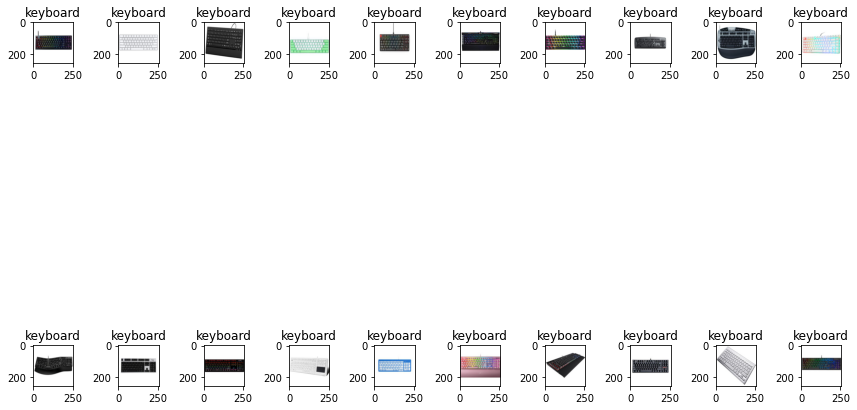

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
shuffle_indices = np.random.permutation(20)
for i in range(0, 20):
    plt.subplot(2, 10, i+1)
    image = x_train[shuffle_indices[i]]
    plt.title(labels[int(y_train[shuffle_indices[i]])])
    plt.imshow(image/255)

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    fill_mode="nearest",
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    brightness_range=[0.4,1.5],
    horizontal_flip=True)

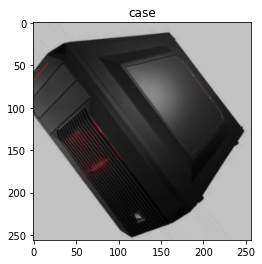

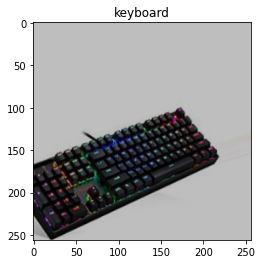

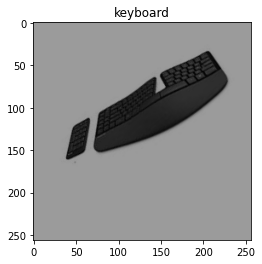

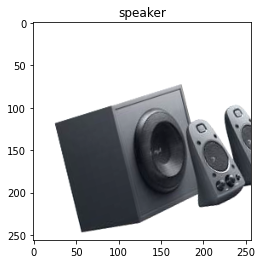

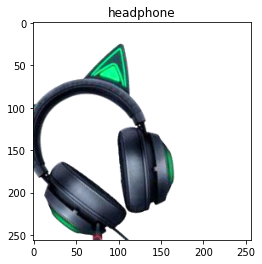

In [ ]:
batch_size = 50
x_train = x_train/255
x_val = x_val/255
example_x, example_y = datagen.flow(x_train, y_train, batch_size=5).next()
for i in range(0,5):
    plt.imshow(example_x[i].astype('uint8'))
    #plt.imshow(example_x[i])
    plt.title(labels[int(example_y[i])])
    plt.show()

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from keras import Sequential
from tensorflow.keras.applications import VGG16

from tensorflow.keras import optimizers


IMAGE_SIZE = 256

#Covolution
conv_base = VGG16(weights='imagenet', # On utilise les poids du réseau déjà pré-entrainé sur la base de données ImageNet
                  include_top=False, # On ne conserve pas la partie Dense du réseau originel
                  input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
#Creation du model

model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation = 'relu', input_shape=(64, 64, 3)))   # Couche dense
model.add(Dense(6, activation = 'softmax'))   # Couche de sortie

conv_base.trainable = False

#https://www.section.io/engineering-education/understanding-loss-functions-in-machine-learning/
#Categorical Cross Entropy Loss
model.compile(loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=optimizers.Adam(learning_rate=1e-5), # Taux d'apprentissage réduit pour ne pas tout casser, ni risquer le sur-apprentissage !
              metrics=['sparse_categorical_accuracy'])

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               8388864   
                                                                 
 dense_3 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 23,105,094
Trainable params: 8,390,406
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
#Training

batch_size = 16

history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), 
                    steps_per_epoch = len(x_train)//batch_size, 
                    epochs = 50,
                    verbose = 1,
                    validation_data = (x_val, y_val)
                    )

Epoch 1/50
45/45 [==============================] - 13s 290ms/step - loss: 1.8675 - sparse_categorical_accuracy: 0.8799 - val_loss: 0.2265 - val_sparse_categorical_accuracy: 0.9456
Epoch 2/50
45/45 [==============================] - 13s 288ms/step - loss: 1.0511 - sparse_categorical_accuracy: 0.9274 - val_loss: 0.2154 - val_sparse_categorical_accuracy: 0.9524
Epoch 3/50
45/45 [==============================] - 13s 288ms/step - loss: 1.0604 - sparse_categorical_accuracy: 0.9204 - val_loss: 0.2083 - val_sparse_categorical_accuracy: 0.9592
Epoch 4/50
45/45 [==============================] - 15s 328ms/step - loss: 0.6429 - sparse_categorical_accuracy: 0.9372 - val_loss: 0.2022 - val_sparse_categorical_accuracy: 0.9456
Epoch 5/50
45/45 [==============================] - 13s 289ms/step - loss: 0.8493 - sparse_categorical_accuracy: 0.9330 - val_loss: 0.2248 - val_sparse_categorical_accuracy: 0.9388
Epoch 6/50
45/45 [==============================] - 13s 289ms/step - loss: 0.6553 - sparse_cate

In [ ]:
conv_base.trainable = True
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 23,105,094
Trainable params: 23,105,094
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), 
                    steps_per_epoch = len(x_train)//batch_size, 
                    epochs = 50,
                    verbose = 1,
                    validation_data = datagen.flow(x_val, y_val, batch_size=50)
                    )

Epoch 1/50
45/45 [==============================] - 16s 347ms/step - loss: 0.0883 - sparse_categorical_accuracy: 0.9832 - val_loss: 0.9143 - val_sparse_categorical_accuracy: 0.9388
Epoch 2/50
45/45 [==============================] - 15s 333ms/step - loss: 0.1301 - sparse_categorical_accuracy: 0.9818 - val_loss: 1.0793 - val_sparse_categorical_accuracy: 0.9252
Epoch 3/50
45/45 [==============================] - 15s 331ms/step - loss: 0.0587 - sparse_categorical_accuracy: 0.9860 - val_loss: 1.3177 - val_sparse_categorical_accuracy: 0.9116
Epoch 4/50
45/45 [==============================] - 15s 328ms/step - loss: 0.1493 - sparse_categorical_accuracy: 0.9860 - val_loss: 0.7729 - val_sparse_categorical_accuracy: 0.9388
Epoch 5/50
45/45 [==============================] - 15s 329ms/step - loss: 0.0954 - sparse_categorical_accuracy: 0.9860 - val_loss: 0.8722 - val_sparse_categorical_accuracy: 0.9184
Epoch 6/50
45/45 [==============================] - 15s 339ms/step - loss: 0.1658 - sparse_cate

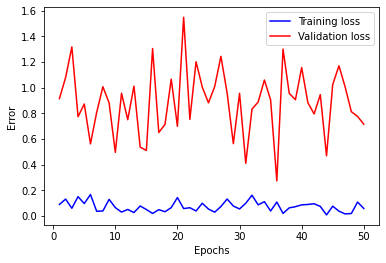

In [ ]:
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.plot(np.arange(1 , 51, 1),
         history.history['loss'],
         label = 'Training loss',
         color = 'blue')
plt.plot(np.arange(1 , 51, 1),
         history.history['val_loss'], 
         label = 'Validation loss',
         color = 'red')
plt.legend()
plt.show()

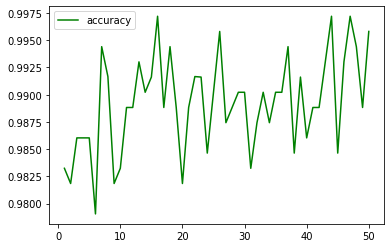

In [ ]:
plt.plot(np.arange(1 , 51, 1),
         history.history['sparse_categorical_accuracy'], 
         label = 'accuracy',
         color = 'green')
plt.legend()
plt.show()

In [ ]:
y_pred=model.predict(x_test)

In [ ]:
y_pred

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 2.26573745e-25, 0.00000000e+00, 5.15292487e-30,
        1.95333694e-25, 1.13346720e-32],
       [1.00000000e+00, 6.04614098e-21, 1.87044469e-35, 7.68437929e-20,
        3.17398145e-31, 2.28666923e-20],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        6.58167480e-29, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.55044906e-22,
        0.00000000e+00, 4.51429578e-35],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 

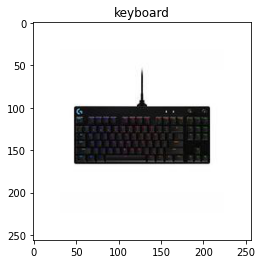

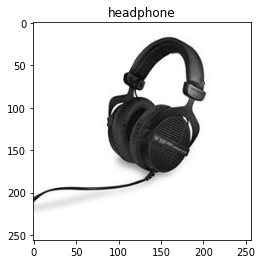

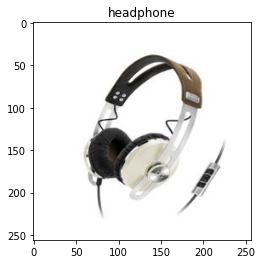

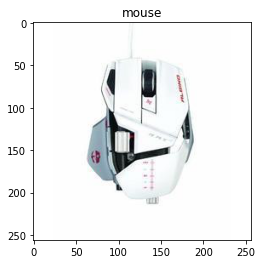

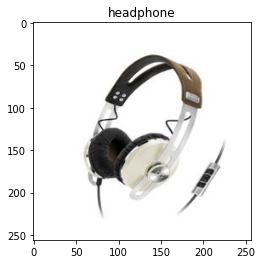

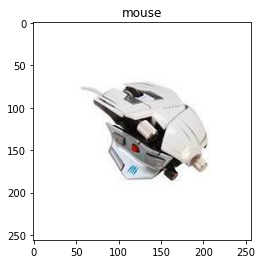

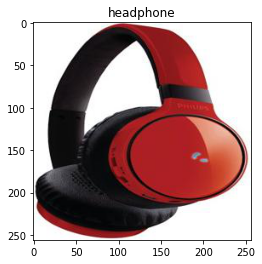

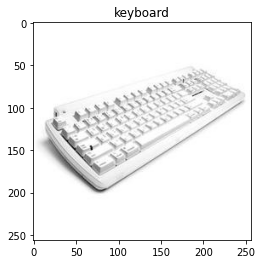

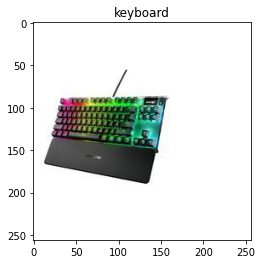

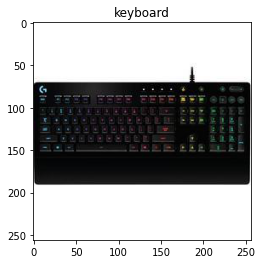

In [ ]:
import random
for j in range(0,10):
    i= int(random.random()*100)
    plt.imshow(x_test[i].astype('uint8'))
    ind_label=np.argmax(y_pred[i], axis=0)
    plt.title(labels[ind_label])
    plt.show()

In [ ]:
model.save('./tensorflow_model.h5')

In [ ]:
import tensorflow
model = tensorflow.keras.models.load_model('./tensorflow_model.h5')